In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib

In [3]:
numpy.random.seed(1234)

In [4]:
# data set generation
n_dim = 2

n_mean1 = numpy.array([-1., -1.])
n_cov1 = numpy.diag([0.5, .5])
n_mean2 = numpy.array([1., 1.])
n_cov2 = numpy.diag([0.5, .5])

p_mean1 = numpy.array([-1., 1.])
p_cov1 = numpy.diag([.5, .5])
p_mean2 = numpy.array([1., -1.])
p_cov2 = numpy.diag([.5, .5])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos * 2) 
pos_x = numpy.concatenate([npr.randn(n_pos, n_dim) * numpy.diag(p_cov1)[None, :] + p_mean1[None,:],
                           npr.randn(n_pos, n_dim) * numpy.diag(p_cov2)[None, :] + p_mean2[None,:]])
n_pos *= 2
# generate negative examples
n_neg = 50
neg_y = numpy.zeros(n_neg * 2) 
neg_x = numpy.concatenate([npr.randn(n_neg, n_dim) * numpy.diag(n_cov1)[None, :] + n_mean1[None,:],
                           npr.randn(n_neg, n_dim) * numpy.diag(n_cov2)[None, :] + n_mean2[None,:]])
n_neg *= 2
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = npr.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int32)

y_train = y[:n_tra]
x_train = x[:n_tra]

y_test = y[n_tra:]
x_test = x[n_tra:]

In [5]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [6]:
def rbf(x, bases, width=1.):
    return numpy.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))

In [7]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [8]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_) + (1. - y) * numpy.log(1-y_))
    
    if not avg:
        return d
    return numpy.mean(d)

In [9]:
def cost(w, x, y):
    return logreg_dist(y, x, w, avg=True)

def cost2(x, w, y):
    return logreg_dist(y, x, w, avg=True)

logreg_rule = grad(cost)

logreg_rule2 = grad(cost2)

In [10]:
def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), logreg_rule(w, x, y)

In [11]:
n_bases = 10
adaptive = False

cids = npr.permutation(len(x_train))[:n_bases]
centroids = x_train[cids] # (K, D)

x_tra, x_val = x_train[:80], x_train[80:]
y_tra, y_val = y_train[:80], y_train[80:] # (N, D)

x_tra_ = rbf(x_tra, centroids, 1.)
x_val_ = rbf(x_val, centroids, 1.)
x_tes_ = rbf(x_test, centroids, 1.) # (N, K)

w0 = npr.randn(n_bases+1); w0[-1] = 0.

print ("centroids", centroids)
for i in range(1000000):
    tra_err = cost(w0, x_tra_, y_tra)
    val_err = cost(w0, x_val_, y_val)
    dw = logreg_rule(w0, x_tra_, y_tra)
    w0 = w0 - 1e-3 * dw

    if adaptive:
        dx = logreg_rule2(x_tra_, w0, y_tra) # (N, K)
        two_phi = 2 * x_tra_ # (N, K)
        x_r = x_tra[:,None,:] - centroids[None,:,:] # (N, K, D)
        dc = dx[:,:,None] * two_phi[:,:,None] * x_r
        dc = numpy.mean(dc, axis=0)
        centroids = centroids - 1e-3 * dc

        x_tra_ = rbf(x_tra, centroids, 1.)
        x_val_ = rbf(x_val, centroids, 1.)
        x_tes_ = rbf(x_test, centroids, 1.) # (N, K)    

    if i % 5000 == 0:
        print(tra_err, val_err)
print ("centroids", centroids)

centroids [[-0.71713085  1.7728294 ]
 [-1.44052355 -0.85246002]
 [ 0.01530181  0.42868436]
 [-0.70946334  0.38192204]
 [ 1.08580119  1.49140891]
 [ 0.28171303  1.10535853]
 [ 1.24807146 -0.60170257]
 [-0.57916264  2.19548026]
 [-0.85046474 -0.46172968]
 [-0.96845773 -1.14222034]]
0.94296969974713 1.0964673089428572
0.7931844445946176 0.8961702924585039
0.7006002894479669 0.7568346293235173
0.6295826236681729 0.6506828064936833
0.5738875629782363 0.5692033976290158
0.529654440629178 0.5058304719734336
0.49407056245967046 0.45574302345204326
0.46507344560760916 0.41550941946474884
0.4411462202511762 0.3826887422297118
0.4211667534421979 0.3555286250755621
0.40429809548850415 0.3327552857593762
0.38990985256885935 0.31343024631692773
0.3775220871574289 0.2968525102182241
0.3667653252678332 0.28249132695337215
0.3573519559019034 0.2699395439930404
0.3490556539390831 0.25888089021208494
0.34169645785226754 0.24906676285314733
0.33512984961858616 0.24029956027126512
0.32923868570031645 0.232

In [12]:
#print (res)
#w = res.x

In [13]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.grid('on')

In [14]:
def vis_decision_boundary(w, typ='k--'):

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = rbf(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), centroids, 1.)
    
    pred = logreg(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    
    return plt1

<IPython.core.display.Javascript object>


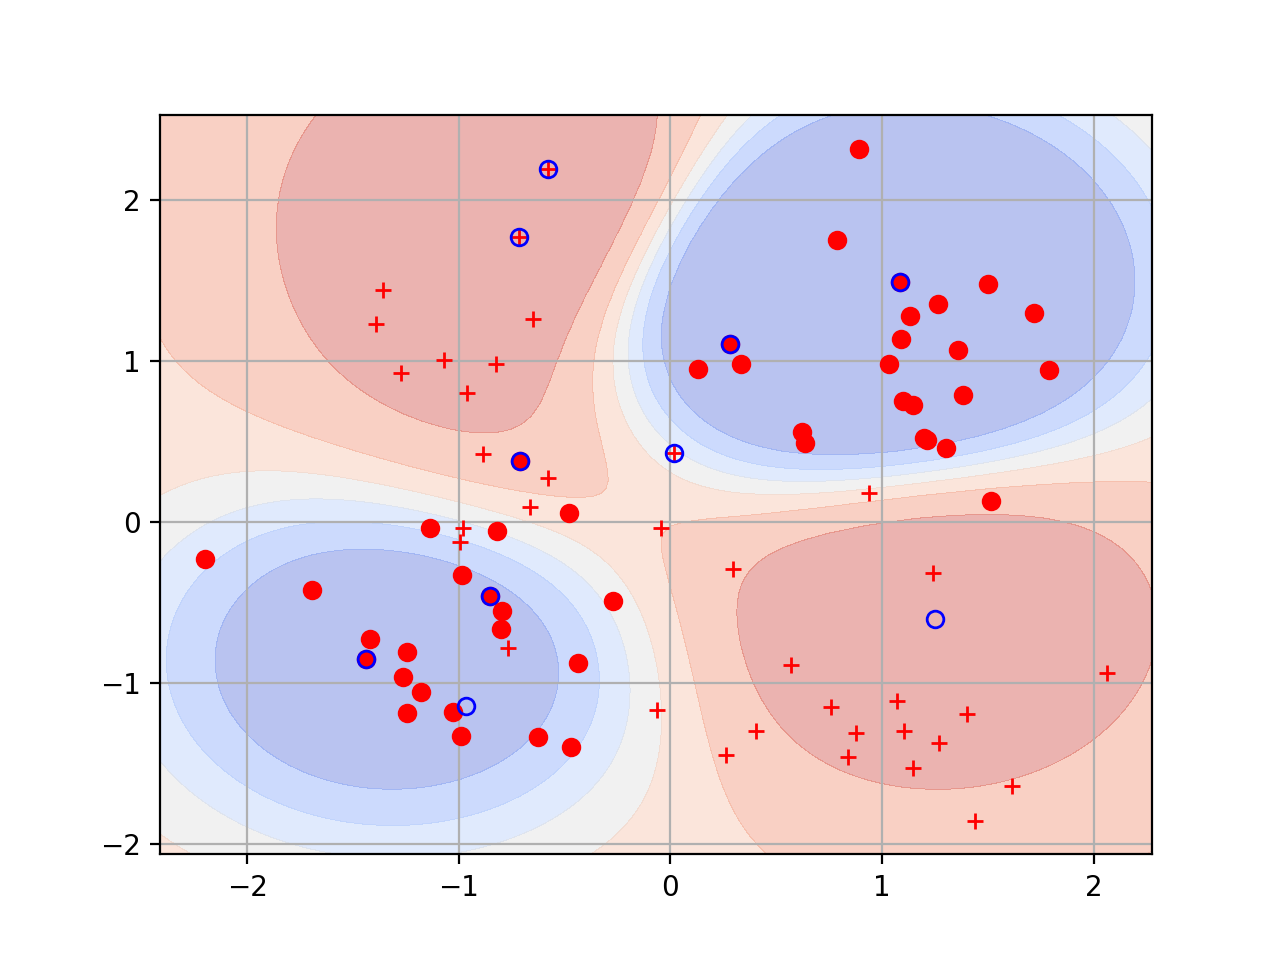

In [15]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_data(centroids, None, c='b')

w = w0

plt1 = vis_decision_boundary(w, 'k--')

plot.show()

In [16]:
x_tra_ = rbf(x_tra, centroids, 1.)
x_tes_ = rbf(x_test, centroids, 1.)

tra_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tra_, w)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tes_, w)) - y_test)) / numpy.float(len(y_test))

print ('Training error rate {}, Test error rate {}'.format(tra_er, tes_er))

Training error rate 0.0875, Test error rate 0.05
